In [518]:
import os
import datetime
from datetime import date
from time import sleep
from unittest import case
from random import randrange


from selenium import webdriver
# import random_user_agent
from selenium.common.exceptions import TimeoutException, WebDriverException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.proxy import Proxy, ProxyType 
from webdriver_manager.chrome import ChromeDriverManager

# from random_user_agent.user_agent import UserAgent
# from random_user_agent.params import SoftwareName, OperatingSystem

import json
import re
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

In [519]:
class selenium_engine:
    def __init__(self):
        # user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--incognito')
        chrome_options.add_argument('headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--window-size=1420,1080')
        chrome_options.add_argument("--disable-gpu")
        # chrome_options.add_argument("--remote-debugging-port=9222")
        chrome_options.add_argument('--disable-dev-shm-usage')
        # chrome_options.add_argument('--single-process')
        # chrome_options.add_argument(f'user-agent={user_agent}')
        # chrome_options.add_experimental_option("excludeSwitches", ['enable-automation'])
        # chrome_options.add_argument("--disable-blink-features");
        # chrome_options.add_argument("--disable-blink-features=AutomationControlled");

        # is_AWS = os.environ['is_AWS']

        # ChromeDriverManager
        # chrome_options.binary_location = '/opt/headless-chromium'
        # self.browser = webdriver.Chrome('/opt/chromedriver',options=chrome_options)
        self.browser = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)


In [528]:
class crawler:
    def __init__(self):
        print("===crawler init ===")
        self.browser = None

    def get_browser(self):
        engine = selenium_engine()
        self.browser = engine.browser

    def wait_by_class_name(self, class_name):
        timeout = 10
        try:
            element_present = EC.presence_of_element_located((By.CLASS_NAME, class_name))
            WebDriverWait(self.browser, timeout).until(element_present)
        except TimeoutException:
            print("Timed out waiting for page to load")
        finally:
            print("Page loaded")
        sleep(5)

    def scroll_down(self, count):
        for i in range(count):
            self.browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            sleep(5)

    def login_to_FB(self, email,pwd):
        browser = self.browser
        browser.get("http://www.facebook.com")
        username = browser.find_element_by_id("email")
        password = browser.find_element_by_id("pass")
        submit = browser.find_element(by=By.CSS_SELECTOR, value='button[name="login"]')
        sleep(1)
        username.send_keys(email)
        sleep(1)
        password.send_keys(pwd)
        sleep(1)
        submit.click()
        sleep(10)

    def login_to_LearnMode(self, email, pwd):
        browser = self.browser
        browser.get("https://www.learnmode.net/login")
        user_selector = browser.find_element(by=By.CSS_SELECTOR, value='.account-input-div input')
        password_selector = browser.find_element(by=By.CSS_SELECTOR, value='.password-input-div input')
        submit_selector = browser.find_element(by=By.CSS_SELECTOR, value='#loginModal .user-input-block .main-btn-div button')
        sleep(1)
        user_selector.send_keys(email)
        sleep(1)
        password_selector.send_keys(pwd)
        sleep(1)
        submit_selector.click()
        sleep(10)

    def save_cookies_to_json(self, file_name):
        browser = self.browser
        cookies = browser.get_cookies()
        json_object = json.dumps(cookies)
        file = open(file_name, "w")
        file.write(json_object)
        file.close()

    def quit_browser(self):
        browser = self.browser
        browser.quit()



In [529]:
class LearnModeCrawler(crawler):    
    def __init__(self):
        print("===LearnModeCrawler init ===")

    def fetch_data(self, url):
        self.get_browser()
        email = "purpleice9765@msn.com"
        pw = "learnmode9765"
        self.login_to_LearnMode(email, pw)
        data_soup = self.fetch_url_data(url)  
        
        return data_soup

    def fetch_url_data(self, url):
        print(f"===fetch:{url}===")
        browser = self.browser
        browser.get(url)
        sleep(5)

        chapter_items = browser.find_elements(by=By.CSS_SELECTOR, value=".chapter-item")
        del chapter_items[0]

        for chap in chapter_items:
            chap.click()
            sleep(1)

        chapter_name_list = []
        names = browser.find_elements(by=By.CSS_SELECTOR, value=".chapter-name")
        for n in names:
            chapter_name_list.append(n.text)
        del chapter_name_list[0]


        resources = browser.find_elements(by=By.CSS_SELECTOR, value='.resource-list')
        content_link_list = []
        for resource in resources:
            link_list = []
            links = resource.find_elements(by=By.CSS_SELECTOR, value="a")
            for link_ele in links:
                link = link_ele.get_attribute("href")
                link_list.append(link)
            content_link_list.append(link_list)
        content_link_list
        del content_link_list[0]


        num = len(chapter_name_list)

        content_data_soup_list = []
        for urls in content_link_list:
            content_link_data_soup = []
            for _url in urls:
                print(_url)
                browser.get(_url)
                sleep(5)
                data_soup = BeautifulSoup(browser.page_source, 'html.parser')
                content_link_data_soup.append(data_soup)

            content_data_soup_list.append(content_link_data_soup)
        print(f"===fetch:{url} done===")
        
        return [chapter_name_list, content_data_soup_list]
    
    def get_attachment_data(self, url):
        self.get_browser()
        email = "purpleice9765@msn.com"
        pw = "learnmode9765"
        self.login_to_LearnMode(email, pw)
        browser = self.browser
        browser.get(url)
        sleep(5)
        file_items = browser.find_elements(by=By.CSS_SELECTOR, value=".file-item")
        file_items_num = len(file_items)
        attachment_list = []
        for i in range(file_items_num):
            file_items = browser.find_elements(by=By.CSS_SELECTOR, value=".file-item")
            print(i)
            file_name = file_items[i].text
            print(file_name)
            file_items[i].click()
            sleep(1)
            img_modal = browser.find_elements(by=By.CSS_SELECTOR, value=".modal.show")
            is_img = len(img_modal) > 0 
            if is_img:
                link_selector = browser.find_elements(by=By.CSS_SELECTOR, value=".modal.show img")[0]
                file_link = link_selector.get_attribute('src')
                browser.refresh();
                sleep(3)
            else:
                network = browser.execute_script("var performance = window.performance || window.mozPerformance || window.msPerformance || window.webkitPerformance || {}; var network = performance.getEntries() || {}; return network;")
                file_link = network[-1]["name"]

            attachment_data = {
                "file_name": file_name,
                "file_link": file_link
            }
            attachment_list.append(attachment_data)

        self.quit_browser()
        return attachment_list


        
    def get_data_json(self, data):
        chapter_name_list = data[0]
        content_data_soup_list = data[1]
        data_json = []

        for i, data_soups in enumerate(content_data_soup_list):
            chapter_data = {}
            chapter_data["chapter_name"] = chapter_name_list[i]
            chapter_data["chapter_index"] = i
            chapter_data["chapter_content"] = []
            
            for data_soup in data_soups:                
                try:
                    title_selector = ".title-wrapper .title-text"
                    title = data_soup.select_one(title_selector).text
                except:
                    title_selector = ".title-lg"
                    title = data_soup.select_one(title_selector).text

                try:
                    link_selector = ".resource-item.active"
                    link = data_soup.select_one(link_selector)['href']
                except:
                    link_selector = ".nav-item-section.selected a"
                    link = data_soup.select_one(link_selector)['href']

                pattern = r'\/course\/.*?\/.*?\/(.*?)\/'
                link_type = re.findall(pattern, link)[0]

                content_link = ""
                attachment = []
                if link_type == "video":
                    iframe_src = data_soup.select_one("iframe")['src']
                    pattern = r"embed\/(.*?)\?"
                    youtube_id = re.findall(pattern, iframe_src)[0]
                    content_link = f"https://www.youtube.com/watch?v={youtube_id}"
                elif link_type == "hyperlink":
                    content_link_selector = ".hyperlink .content a"
                    content_link = data_soup.select_one(content_link_selector)['href']
                elif link_type == "book":
                    content_link_selector = "iframe.pdf-reader"
                    content_link = data_soup.select_one(content_link_selector)['src']
                elif link_type == "homework":
                    url = "https://www.learnmode.net" + link
                    attachment = self.get_attachment_data(url)

                content_data = {
                    "title": title,
                    "link": link,
                    "link_type": link_type,
                    "content_link": content_link,
                    "attachment": attachment
                }
                
                chapter_data["chapter_content"].append(content_data)

            data_json.append(chapter_data)
        print(data_json)
                                
        return data_json

In [530]:
_crawler = LearnModeCrawler()
url = "https://www.learnmode.net/course/472517/content"
data = _crawler.fetch_data(url)
data_json = _crawler.get_data_json(data)
# except Exception as error:
#     print(repr(error))

_crawler.quit_browser()




====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


===LearnModeCrawler init ===


Driver [/Users/young/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache
/var/folders/tp/_sbk2b9j5hn7mr_jl_gg2djh0000gn/T/ipykernel_84168/1327015267.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.browser = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)


===fetch:https://www.learnmode.net/course/472517/content===
https://www.learnmode.net/course/472517/28264984/video/5320608
https://www.learnmode.net/course/472517/28264984/hyperlink/2241789
https://www.learnmode.net/ymca/course/472517/28265990/book/5055501
https://www.learnmode.net/course/472517/28264984/homework/2216717
https://www.learnmode.net/course/472517/28273181/hyperlink/2242452
https://www.learnmode.net/course/472517/28273181/homework/2217579
https://www.learnmode.net/course/472517/28273181/video/5323095
https://www.learnmode.net/ymca/course/472517/28273199/book/5056578




====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


===fetch:https://www.learnmode.net/course/472517/content done===


Driver [/Users/young/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache


0
logo.png
{'file_name': 'logo.png', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/535f9b253692.png'}
1
QuizizzSampleSpreadsheet.xlsx
{'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/45cff62cfa58.xlsx'}
2
5d2ec90928737_cve3rkw-1.jpeg




====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


{'file_name': '5d2ec90928737_cve3rkw-1.jpeg', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/afe98c6a64ae.jpeg'}
[{'file_name': 'logo.png', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/535f9b253692.png'}, {'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/45cff62cfa58.xlsx'}, {'file_name': '5d2ec90928737_cve3rkw-1.jpeg', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/afe98c6a64ae.jpeg'}]
attachment2:[{'file_name': 'logo.png', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/535f9b253692.png'}, {'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea

Driver [/Users/young/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache


0
QuizizzSampleSpreadsheet.xlsx
{'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/33/3391e47e8c816d24/3046fe49cfd1.xlsx'}
[{'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/33/3391e47e8c816d24/3046fe49cfd1.xlsx'}]
attachment2:[{'file_name': 'QuizizzSampleSpreadsheet.xlsx', 'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/33/3391e47e8c816d24/3046fe49cfd1.xlsx'}]
[{'chapter_name': '我是 chp1', 'chapter_index': 0, 'chapter_content': [{'title': ' 不能不聽的周杰伦100首歌 - 100 songs of Jay Chou You Must listen ', 'link': '/course/472517/28264984/video/5320608', 'link_type': 'video', 'content_link': 'https://www.youtube.com/watch?v=lE-XMbjdSzY', 'attachment': []}, {'title': ' Quizizz ', 'link': '/course/472517/28264984/hyperlink/2241789', 'link_type': 'hyperlink', 'content_link': 'https://quizizz.c

In [525]:
_crawler.quit_browser()


{'chapter_name': '我是 chap2',
 'chapter_index': 1,
 'chapter_content': [<html lang="zh-Hant-TW"><head><meta charset="utf-8"/><meta name="google" value="notranslate"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="width=device-width,initial-scale=1" name="viewport"/><meta content="Learnmode Education" property="og:site_name"/><meta content="/upload/home/og_image.png" property="og:image"/><meta content="website" property="og:type"/><link href="/webpack-compiled/favicon.ico" rel="icon"/><title>LearnMode 學習吧</title><meta content="全台最多師生使用的學習平台，近20萬堂學科和素養課程，幫孩子學得更好！" name="description"/><meta content="LearnMode 學習吧" property="og:title"/><meta content="全台最多師生使用的學習平台，近20萬堂學科和素養課程，幫孩子學得更好！" property="og:description"/><meta content="https://www.learnmode.net/" property="og:url"/><meta content="zh_tw" property="og:locale"/><script async="" crossorigin="anonymous" src="https://connect.facebook.net/zh_TW/sdk.js?hash=84c9a30ec41a229f9ef5923002d4076c"></script><script async="" s
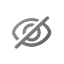
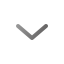
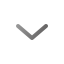
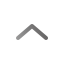
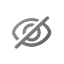
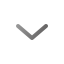
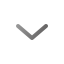
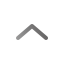
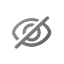
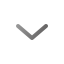
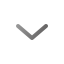
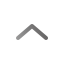

In [515]:
data_json[1]

In [494]:
data_soup = data_json[0]["chapter_content"][3]

In [506]:
_crawler = LearnModeCrawler()
url = "https://www.learnmode.net/course/472517/28264984/homework/2216717"
att = _crawler.get_attachment_data(url)
att





====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


===LearnModeCrawler init ===


Driver [/Users/young/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache
/var/folders/tp/_sbk2b9j5hn7mr_jl_gg2djh0000gn/T/ipykernel_84168/595343345.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.browser = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)


0
logo.png
1
QuizizzSampleSpreadsheet.xlsx
2
5d2ec90928737_cve3rkw-1.jpeg


[{'file_name': 'logo.png',
  'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/535f9b253692.png'},
 {'file_name': 'QuizizzSampleSpreadsheet.xlsx',
  'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/45cff62cfa58.xlsx'},
 {'file_name': '5d2ec90928737_cve3rkw-1.jpeg',
  'file_link': 'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/afe98c6a64ae.jpeg'}]

In [496]:



try:
    title_selector = ".title-wrapper .title-text"
    title = data_soup.select_one(title_selector).text
except:
    title_selector = ".title-lg"
    title = data_soup.select_one(title_selector).text

try:
    link_selector = ".resource-item.active"
    link = data_soup.select_one(link_selector)['href']
except:
    link_selector = ".nav-item-section.selected a"
    link = data_soup.select_one(link_selector)['href']
    
pattern = r'\/course\/.*?\/.*?\/(.*?)\/'
link_type = re.findall(pattern, link)[0]

content_link = ""
attachment = []
if link_type == "video":
    iframe_src = data_soup.select_one("iframe")['src']
    pattern = r"embed\/(.*?)\?"
    youtube_id = re.findall(pattern, iframe_src)[0]
    content_link = f"https://www.youtube.com/watch?v={youtube_id}"
elif link_type == "hyperlink":
    content_link_selector = ".hyperlink .content a"
    content_link = data_soup.select_one(content_link_selector)['href']
elif link_type == "book":
    content_link_selector = "iframe.pdf-reader"
    content_link = data_soup.select_one(content_link_selector)['src']
elif link_type == "homework":
    url = "https://www.learnmode.net/" + link
    attachment = self.get_attachment_data(url)
        

content_data = {
    "title": title,
    "link": link,
    "link_type": link_type,
    "content_link": content_link,
    "attachment": attachment
}

content_data

{'title': ' fgfgdfgfd ',
 'link': '/course/472517/28264984/homework/2216717',
 'link_type': 'homework',
 'content_link': '',
 'attachment': []}

In [485]:
_crawler = LearnModeCrawler()
_crawler.get_browser()
browser = _crawler.browser
email = "purpleice9765@msn.com"
pw = "learnmode9765"
_crawler.login_to_LearnMode(email,pw)
url = "https://www.learnmode.net/course/472517/28264984/homework/2216717"
browser.get(url)



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome


===LearnModeCrawler init ===


Driver [/Users/young/.wdm/drivers/chromedriver/mac64_m1/101.0.4951.41/chromedriver] found in cache
/var/folders/tp/_sbk2b9j5hn7mr_jl_gg2djh0000gn/T/ipykernel_84168/595343345.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.browser = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)


In [493]:
browser = _crawler.browser
browser.refresh()
sleep(2)
file_items = browser.find_elements(by=By.CSS_SELECTOR, value=".file-item")
file_items_num = len(file_items)
for i in range(file_items_num):
    file_items = browser.find_elements(by=By.CSS_SELECTOR, value=".file-item")
    print(i)
    file_name = file_items[i].text
    print(file_name)
    file_items[i].click()
    sleep(1)
    img_modal = browser.find_elements(by=By.CSS_SELECTOR, value=".modal.show")
    is_img = len(img_modal) > 0 
    if is_img:
        link_selector = browser.find_elements(by=By.CSS_SELECTOR, value=".modal.show img")[0]
        file_link = link_selector.get_attribute('src')
        
        browser.refresh();
        sleep(3)
    else:
        network = browser.execute_script("var performance = window.performance || window.mozPerformance || window.msPerformance || window.webkitPerformance || {}; var network = performance.getEntries() || {}; return network;")
        file_link = network[-1]["name"]
    
    attachment_data = {
        "file_name": file_name,
        "file_link": file_link
    }
        
        

0
logo.png
https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/535f9b253692.png
1
QuizizzSampleSpreadsheet.xlsx
https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/45cff62cfa58.xlsx
2
5d2ec90928737_cve3rkw-1.jpeg
https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/afe98c6a64ae.jpeg


In [490]:
network[-1]["name"]

'https://resource.learnmode.net/upload/course/5a/5adaccf6155df301/homework/38/383479e52ef0aea5/45cff62cfa58.xlsx'

In [498]:
browser.quit()